# 6-9. 프로젝트 : 주식 예측에 도전해 보자

###    주요 라이브러리 버전을 확인

In [1]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


###    STEP 1 : 시계열 데이터 준비

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

ts(time series)는 데이터 프레임의 Close 컬럼으로 구성된 시리즈이다. 시계열 분석(시간인덱스와 close 데이터로 이루어짐)

In [3]:
print(type(ts))

<class 'pandas.core.series.Series'>


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


데이터의 생김새를 데이터 프레임 형태로 확인하고 싶어서 df.head()를 통해 확인해보았다.\
칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

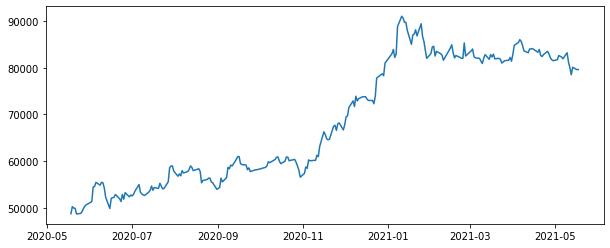

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 4  

plt.plot(ts)

준비된 시계열(종가데이터)를 시각화를 통해 먼저 안정성 여부를 확인해보았다. \
경향성(Trend), 계절성(Seasonality) 측면에서 비안정성 그래프임을 확인하였다.

In [6]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치 유무를 확인하였고 결측치가 없는 것이 확인되었다.

### STEP 2 : 각종 전처리 수행

### Mission!
#### 결측치 처리
#### 로그 변환

결측치 처리에 대하여 삭제(drop)하거나 보간(interpolate)하는 두가지 방법이있는데\
시계열데이터는 시간을 index로 가지는 특성을 가지므로 보간하는 방법을 선택한다.

In [7]:
ts = ts.interpolate(method='time')

print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


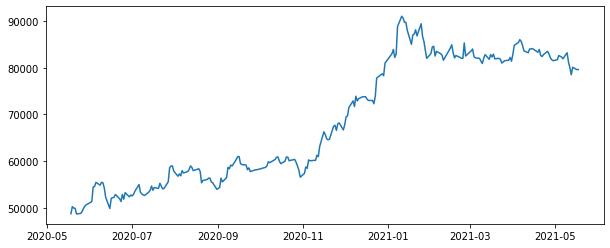

In [8]:
plt.plot(ts)

위 그래프와 다른점이 없었다.

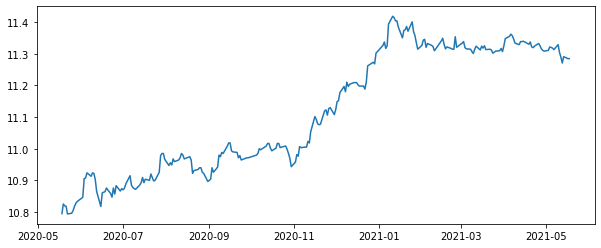

In [9]:
ts_log = np.log(ts)
plt.plot(ts_log)

안정성을 부여하기 위해 로그화를 진행하였으나 그래프에 변동이 없었다.

### STEP 3 : 시계열 안정성 분석

### Mission!
#### 정성적 그래프 분석
#### 정량적 Augmented Dicky-Fuller Test
#### 시계열 분해(Time Series Decomposition)
#### Residual 안정성 확인

정성적 그래프 분석

In [10]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('정성적 그래프 분석을 위한 함수 정의하기 이동평균과 이동표준편차로')

정성적 그래프 분석을 위한 함수 정의하기 이동평균과 이동표준편차로


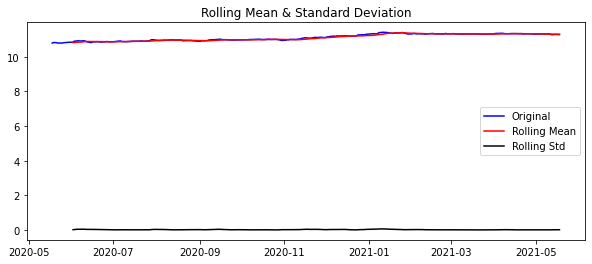

In [11]:
plot_rolling_statistics(ts_log, window=12)

윈도우 값이 12인 경우 월별 이동평균과 이동표준편차 그래프를 확인할 수 있으며 그래프의 형태는 위와 같았다.\
오리지날값과 이동평균은 거의 값이 흡사한 것을 확인할 수 있었고, 이동표준편차는 0~1 값 사이의 값 분포를 볼 수 있었다.\
시각화에서 그래프가 거의 일직선으로 나온것을 보았을 때 좀더 값의 디테일한 차이를 보고싶다는 생각이 들었고,\
시각화의 방법에 문제가 있나? 하는 생각이 들었다.

정량적 adfuller test

In [12]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('정량적 데이터 분석을 위한 AD-fuller test 함수 정의하기')

정량적 데이터 분석을 위한 AD-fuller test 함수 정의하기


In [13]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value                          0.663778 의 값을 가진것을 확인하였다.\
따라서 ts 시계열이 안정적이지 않은 귀무가설은 기각될 수가 없다.\
이 시계열이 안정적인 시계열이라고 말할 수 없다.

시계열 분해

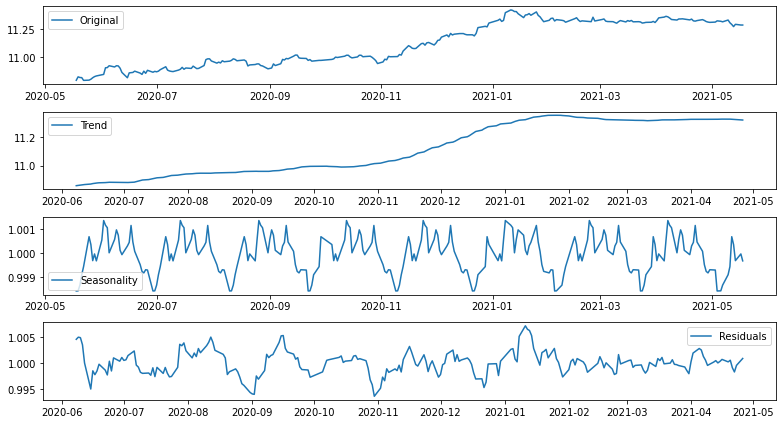

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trent(추세), seasonality를 직접 분리해 내 본다.(시계열 분해)\
위 그래프를 통해 오리지날 데이터와 Trend, Seasonality, Residuals의 시각화가 명확하게 이루어진 모습을 확인할 수 있었다.

In [15]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


정량적 그래프 분석에서 얻었던 값들과 비교해보았다. 모든 값에 변화가 있었고,\
이 값들의 변화가 구체적으로 무엇을 의미하는지 이해하기 어려웠다.\
P-value 값이 6.234854e-08 으로 변화하였다.

### STEP 4 : 학습, 테스트 데이터셋 생성

### Mission!
#### 학습, 테스트 데이터셋 분리

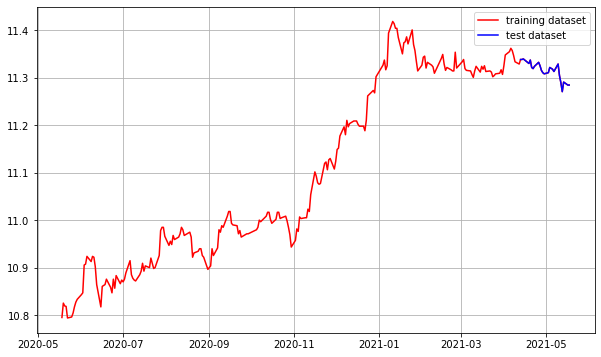

In [16]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

노드에서와 같이 시계열 데이터에서 학습데이터와 테스트 데이터의 비율을 9:1로 분리하였다.\
시계열 예측은 가장 나중 데이터를 테스트용으로 사용하는 것이 타당하다는 것을 학습하였다.

In [17]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


데이터셋의 형태를 확인하였다.\
종가데이터로 날짜기준 실수형 데이터의 배열의 형태 및 개수를 확인하였다.

### STEP 5 : 적정 ARIMA 모수 찾기

### Mission!
#### ACF, PACF 그려보기 -> p,q 구하기
#### 차분 안정성 확인 -> d 구하기

ARIMA 의 모수 찾기\
\
p : 자기회귀 모형(AR)의 시차\
d : 차분 누적(I)횟수\
q : 이동평균 모형(MA)의 시차

ACF\
\
시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수\
주어진 시계열의 현재 값이 과거값과 어떻게 상관되는지 설명함.\
ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄\
\
PACF\
\
다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수\
k 이외의 모든 시차를 갖는 관측치의 영향력을 배제한 가운데 특정 두 관측치가 얼마나 관련이 있는지 나타내는 척도.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


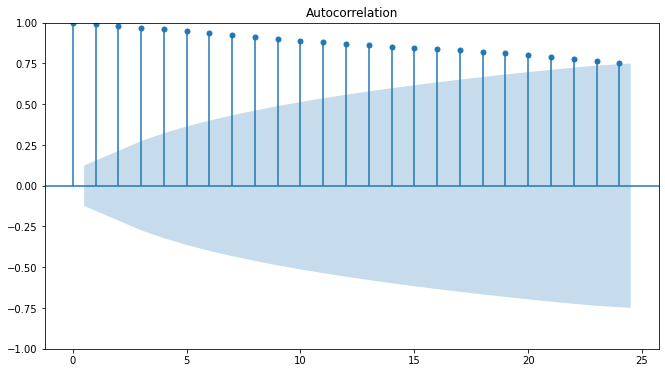

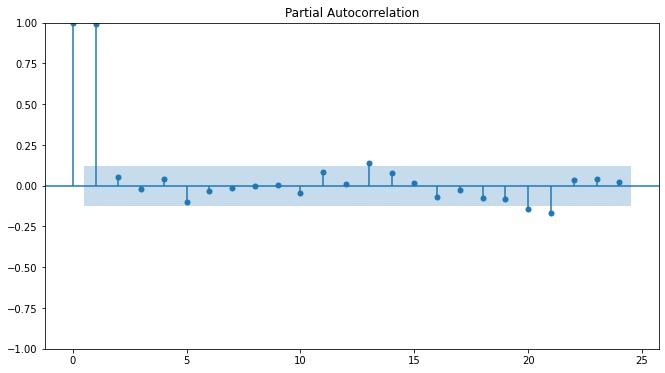

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF 그래프를 볼 때 p = 1이 적합한 것으로 보임, 2 이후에 0에 가까워지고 있음. \
ACF는 점차적으로 감소 q에 대한 적합한 값을 찾기 어려움. 0 이후로 점차 감소하고있으므로 q = 0으로 둘 수 있다.

d를 구하기 위해 차분을 구해보고 시계열이 안정된 상태인지 확인해보기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


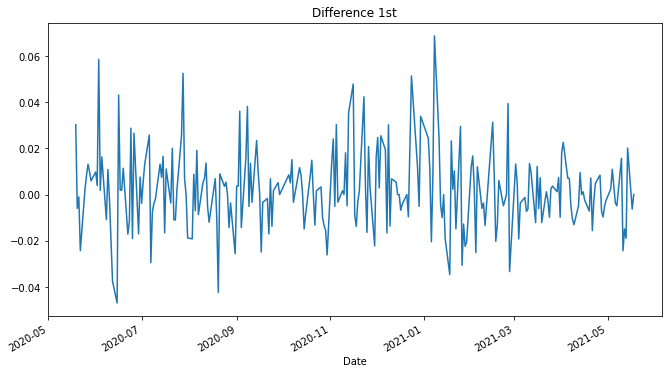

In [19]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


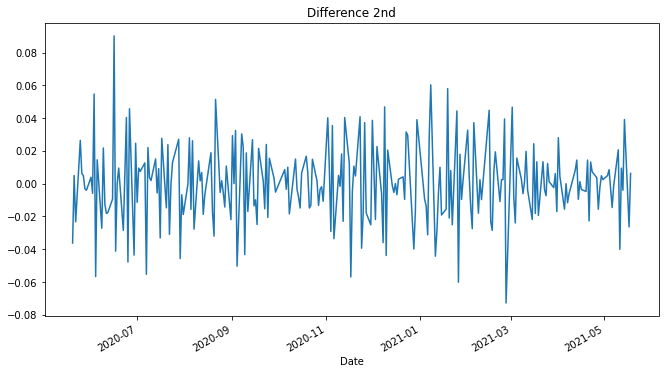

In [20]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

2차 차분까지 구해보았다. 안정화 상태가 어떤 것인지 잘 모르겠다.\
p-value 값이 2.183738e-28에서  3.525823e-18으로 변화하였다.\
그래프를 보았을 때 형태적으로 좀더 안정된 경향성을 보이는 듯 하다.\
d 값은 어떻게 설정하는게 맞는지 잘 모르겠다.\

그룹스터디 이후 부동소수점 개념에 대한 내용을 복습하였다.\
결론적으로 2차차분을 할 필요가 없었고, 1차차분 이후 p-value가 안정적인 모습임을 확인할 수 있었다.

### STEP 6 : ARIMA 모델 훈련과 테스트

### Mission!
#### ARIMA 모델 빌드와 훈련
#### 모델 테스트 및 플로팅
#### 최종 예측 모델 정확도 측정(MAPE)

ARIMA 모델 빌드와 훈련

In [21]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Fri, 06 Jan 2023   AIC                          -1162.976
Time:                        03:44:59   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

model = ARIMA(train_data, order=(2, 1, 0)) # 모수는 이전 그래프를 참고 \
아리마 모델을 만드는 코드에서 모수 값 설정에 대한 확신이 들지 않았다. p=1, q=0으로 두어도 될거 같고\
2는 어디서 나온 숫자인지 잘 모르겠다.

모델 테스트 및 플로팅

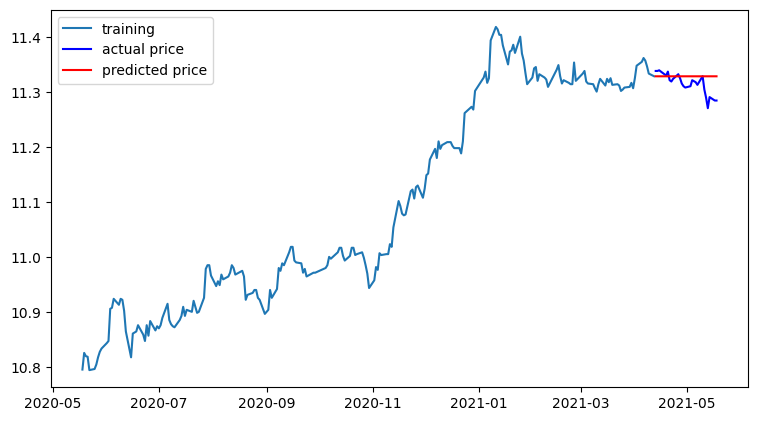

In [22]:
model = ARIMA(train_data, order=(1, 1, 0))  # p값을 2으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc.index = test_data.index
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [23]:
test_data

Date
2021-04-13    11.338572
2021-04-14    11.338572
2021-04-15    11.339762
2021-04-16    11.337381
2021-04-19    11.330204
2021-04-20    11.337381
2021-04-21    11.321765
2021-04-22    11.319341
2021-04-23    11.324183
2021-04-26    11.332602
2021-04-27    11.325390
2021-04-28    11.315693
2021-04-29    11.310809
2021-04-30    11.308358
2021-05-03    11.310809
2021-05-04    11.321765
2021-05-06    11.318126
2021-05-07    11.313254
2021-05-10    11.329003
2021-05-11    11.304671
2021-05-12    11.289782
2021-05-13    11.270854
2021-05-14    11.291031
2021-05-17    11.284769
2021-05-18    11.284769
Name: Close, dtype: float64

In [24]:
fc

Date
2021-04-13    11.328843
2021-04-14    11.328838
2021-04-15    11.328837
2021-04-16    11.328837
2021-04-19    11.328837
2021-04-20    11.328837
2021-04-21    11.328837
2021-04-22    11.328837
2021-04-23    11.328837
2021-04-26    11.328837
2021-04-27    11.328837
2021-04-28    11.328837
2021-04-29    11.328837
2021-04-30    11.328837
2021-05-03    11.328837
2021-05-04    11.328837
2021-05-06    11.328837
2021-05-07    11.328837
2021-05-10    11.328837
2021-05-11    11.328837
2021-05-12    11.328837
2021-05-13    11.328837
2021-05-14    11.328837
2021-05-17    11.328837
2021-05-18    11.328837
Name: predicted_mean, dtype: float64

In [25]:
fc_series

Date
2021-04-13    11.328843
2021-04-14    11.328838
2021-04-15    11.328837
2021-04-16    11.328837
2021-04-19    11.328837
2021-04-20    11.328837
2021-04-21    11.328837
2021-04-22    11.328837
2021-04-23    11.328837
2021-04-26    11.328837
2021-04-27    11.328837
2021-04-28    11.328837
2021-04-29    11.328837
2021-04-30    11.328837
2021-05-03    11.328837
2021-05-04    11.328837
2021-05-06    11.328837
2021-05-07    11.328837
2021-05-10    11.328837
2021-05-11    11.328837
2021-05-12    11.328837
2021-05-13    11.328837
2021-05-14    11.328837
2021-05-17    11.328837
2021-05-18    11.328837
Name: predicted_mean, dtype: float64

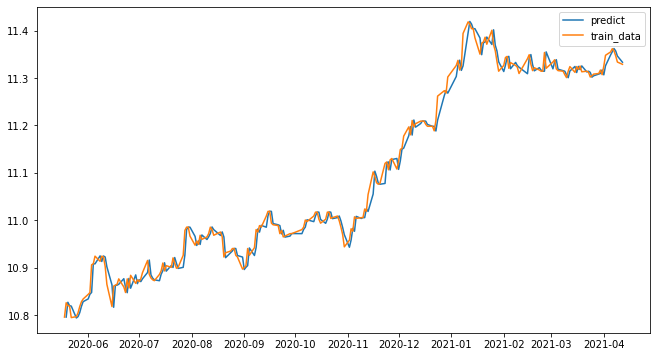

In [26]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

최종 예측 모델 정확도 측정(MAPE)

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


p값을 2로 테스트해 본 결과 MAPE값이 nan값이 나왔다.\
이에 높은 숫자와 0까지 실험해보았는데 계속 nan값이 나왔다....\
p값은 어떻게 찾는걸까?\

ARIMA(p,i,q)\

ARIMA(pacf, diff, acf) 를 통해 p값을 집어넣는 위치를 확인하였다.\
MAPE가 1.74%로 꽤 괜찮은 수치가 나왔다.\
ARIMA 모델링을 하는 코드에서 fc 관련 코드오류가 있었다.\

# 테슬라 주식 예측

In [35]:
df_tsla = pd.read_csv("~/aiffel/TSLA.csv", index_col='Date', parse_dates=True)

df_tsla.shape

(252, 6)

index_col='Date', parse_dates=True ts를 위해 데이터 인덱스 컬럼을 설정하는 것이 중요하다.

In [36]:
df_tsla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2022-01-05 to 2023-01-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       252 non-null    float64
 1   High       252 non-null    float64
 2   Low        252 non-null    float64
 3   Close      252 non-null    float64
 4   Adj Close  252 non-null    float64
 5   Volume     252 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


In [37]:
df_tsla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-05,382.216675,390.113342,360.336670,362.706665,362.706665,80119800
2022-01-06,359.000000,362.666656,340.166656,354.899994,354.899994,90336600
2022-01-07,360.123322,360.309998,336.666656,342.320007,342.320007,84164700
2022-01-10,333.333344,353.033325,326.666656,352.706665,352.706665,91815000
2022-01-11,351.223328,358.616669,346.273346,354.799988,354.799988,66063300


데이터프레임 헤드를 통해 인덱스 컬럼이 Date로 설정되어 있는 것을 확인!

In [38]:
print(type(ts))

<class 'pandas.core.series.Series'>


In [39]:
ts_tsla = df_tsla['Close']

ts_tsla.head()

Date
2022-01-05    362.706665
2022-01-06    354.899994
2022-01-07    342.320007
2022-01-10    352.706665
2022-01-11    354.799988
Name: Close, dtype: float64

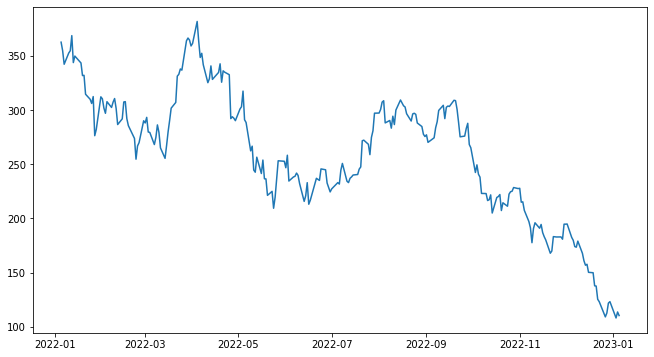

In [40]:
plt.plot(ts_tsla)

In [41]:
ts_tsla[ts_tsla.isna()]

Series([], Name: Close, dtype: float64)

In [42]:
ts_tsla = ts_tsla.interpolate(method='time')

print(ts_tsla[ts_tsla.isna()])

Series([], Name: Close, dtype: float64)


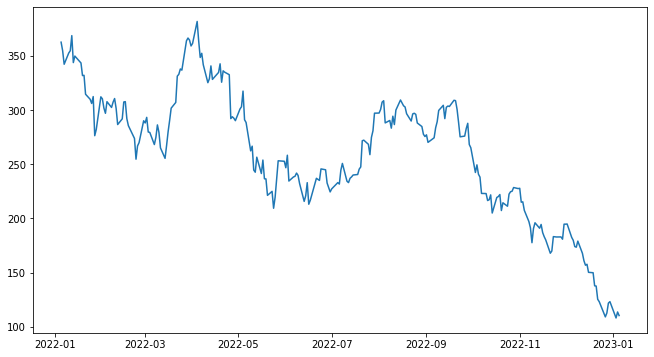

In [43]:
plt.plot(ts_tsla)

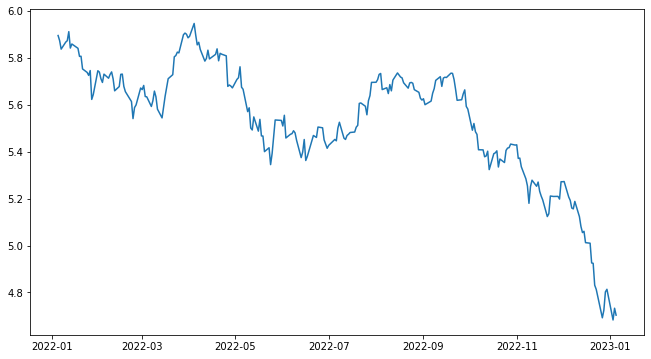

In [44]:
ts_tsla_log = np.log(ts_tsla)
plt.plot(ts_tsla_log)

In [45]:
def plot_rolling_statistics_tsla(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('정성적 그래프 분석을 위한 함수 정의하기 이동평균과 이동표준편차로')

정성적 그래프 분석을 위한 함수 정의하기 이동평균과 이동표준편차로


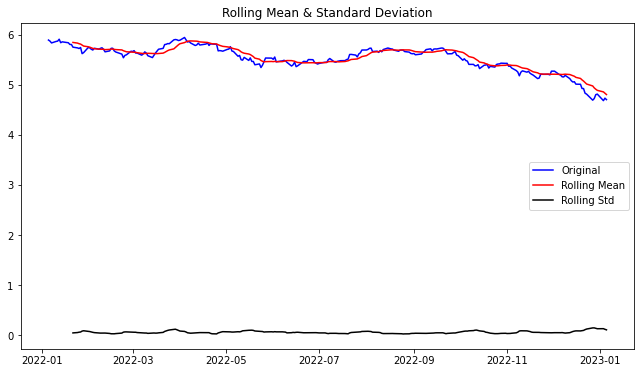

In [46]:
plot_rolling_statistics_tsla(ts_tsla_log, window=12)

In [47]:
def augmented_dickey_fuller_test_tsla(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('정량적 데이터 분석을 위한 AD-fuller test 함수 정의하기')

정량적 데이터 분석을 위한 AD-fuller test 함수 정의하기


In [48]:
augmented_dickey_fuller_test_tsla(ts_tsla)

Results of Dickey-Fuller Test:
Test Statistic                  -0.879240
p-value                          0.794732
#Lags Used                       9.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


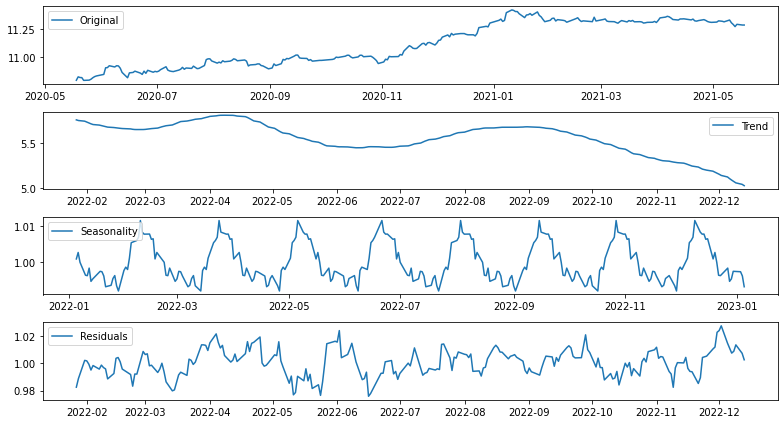

In [53]:
decomposition_tsla = seasonal_decompose(ts_tsla_log, model='multiplicative', period = 30)

trend_tsla = decomposition_tsla.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal_tsla = decomposition_tsla.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual_tsla = decomposition_tsla.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()